In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r^2": r_score,}

In [4]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 hours 14 mins
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_38066_evqt0w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.802 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [16]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_01.02_v2.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['logP']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           molecule_type="amine",
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=unimportant_features_to_drop,)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features or "angle" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

True
128
['avg_atoms_in_cycle', 'nFaHRing', 'chirality', 'PPSA5', 'tpsa+f', 'RPCS', 'mol_num_cycles', 'GeomShapeIndex', 'angle_R2X2R1', 'nN', 'distance_between_atoms_in_f_group_centers', 'nC', 'nFARing', 'angle_R1X1R2', 'f_freedom', 'naHRing', 'nFAHRing', 'cis/trans', 'dipole_moment', 'f_to_fg', 'identificator', 'f_atom_fraction', 'nFRing', 'nFaRing', 'naRing', 'nFHRing', 'PBF', 'nARing', 'nF', 'dihedral_angle', 'nAHRing', 'nO', 'TASA', 'angle_X2X1R1', 'mol_volume', 'FPSA3', 'PNSA5', 'angle_X1X2R2', 'nHRing', 'pKa', 'logP']
dipole_moment outliers indexes: [27]
f_atom_fraction outliers indexes: [69]
mol_volume outliers indexes: [72]
Remains rows:76, amount of features: 41
67 9


In [18]:
train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
# train_df.to_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_pKa_v3.csv')
# test_df.to_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_pKa_v3.csv')

In [8]:
x = train.columns
y = "pKa"
x.remove(y)

aml = H2OAutoML(seed=1, max_runtime_secs=1200)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |█
16:33:38.379: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
16:33:38.380: AutoML: XGBoost is not available; skipping it.
16:33:38.382: _train param, Dropping bad and constant columns: [nN, naRing]
16:33:38.434: _train param, Dropping bad and constant columns: [nN, naRing]
16:33:38.434: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 102.0.
16:33:38.434: _train param, Dropping bad and constant columns: [nN, naRing]
16:33:38.647: _train param, Dropping bad and constant columns: [nN, naRing]
16:33:38.766: _train param, Dropping bad and constant columns: [nN, naRing]
16:33:38.878: _train param, Dropping bad and constant columns: [nN, naRing]
16:33:38.995: _train param, Dropping unused columns: [nN, naRing]
16:33:39.116: _train param, Dropping unused columns: [nN, naRing]
16:33:39.226: _train param, Dropping bad and constant columns: [nN, naRing]

In [9]:
best_model = aml.get_best_model()
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_5_20240205_163338_model_39


Status of Neuron Layers: predicting pKa, regression, gaussian distribution, Quadratic loss, 2 901 weights/biases, 41,2 KB, 1 021 020 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate            rate_rms             momentum    mean_weight             weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  -------------------  -------------------  ----------  ----------------------  -------------------  --------------------  -----------------------
    1        27       Input             0.0
    2        100      RectifierDropout  0.0        0.0   0.0   0.5683448208023415   0.35108625888824463  0.0         -0.0033799754742789515  0.1887342929840088   -0.19874406637389153  0.2561824321746826
    3        1        Linear                       0.0   0.0   0.19204455710947513  0.2936195135116577   0.0         0.003353295464354815    0.08434006571769714  -0.15319895087488558  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.00021928798345099588
RMSE: 0.014808375449420368
MAE: 0.010743228490076535
RMSLE: 0.0014593093651143155
Mean Residual Deviance: 0.00021928798345099588

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.46753638181834206
RMSE: 0.683766321061766
MAE: 0.4967755814957162
RMSLE: 0.07979764503061527
Mean Residual Deviance: 0.46753638181834206

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid
----------------------  ---------  -----------  ------------  ------------
mae                     0.497006   0.01665      0.485233      0.50878
mean_residual_deviance  0.468443   0.0653624    0.422224      0.514661
mse                     0.468443   0.0653624    0.422224      0.514661
r2                      0.816779   0.04793      0.850671      0.782888
residual_deviance       0.468443   0.0653624    0.422224      0.514661
rmse                    0.683593   0.047808     0.649788      0.717399
rmsle                   0.0798038  0.000500865  0.0794496     0.080158

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------
    2024-02-05 16:41:55  0.000 sec                           0         0             0            nan              nan                  nan             nan
    2024-02-05 16:41:55  8 min  3.550 sec  78461 obs/sec     10        1             1020         0.659237         0.434593             0.494222        0.833111
    2024-02-05 16:42:00  8 min  8.552 sec  133043 obs/sec    6540      654           667080       0.0212879        0.000453175          0.0155929       0.999826
    2024-02-05 16:42:02  8 min 10.279 sec  151486 obs/sec    10010     1001          1.02102e+06  0.0148084        0.000219288          0.0107432       0.999916

Variable Importances: 
variable                                   relative_importance    scaled_importance    percentage
-----------------------------------------  ---------------------  -------------------  --------------------
PPSA5                                      1.0                    1.0                  0.06615612346811084
FPSA3                                      0.9248050451278687     0.9248050451278687   0.0611815167494111
dipole_moment                              0.7910289168357849     0.7910289168357849   0.05233140668903417
distance_between_atoms_in_f_group_centers  0.7712917327880859     0.7712917327880859   0.05102567110426177
PBF                                        0.7394132614135742   

TRAIN

In [10]:
preds = best_model.predict(train)
true = train.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.0, 'mae': 0.011, 'r^2': 1.0}

TEST

In [19]:
preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.202, 'mae': 0.392, 'r^2': 0.818}

In [19]:
best_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\01.02.24_features_2.1\pKa\all_molecules(without_angle_feature)_without_outliers\DeepLearning_grid_1_AutoML_3_20240201_153554_model_72')

preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.11, 'mae': 0.285, 'r^2': 0.979}

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_18744\2531905003.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

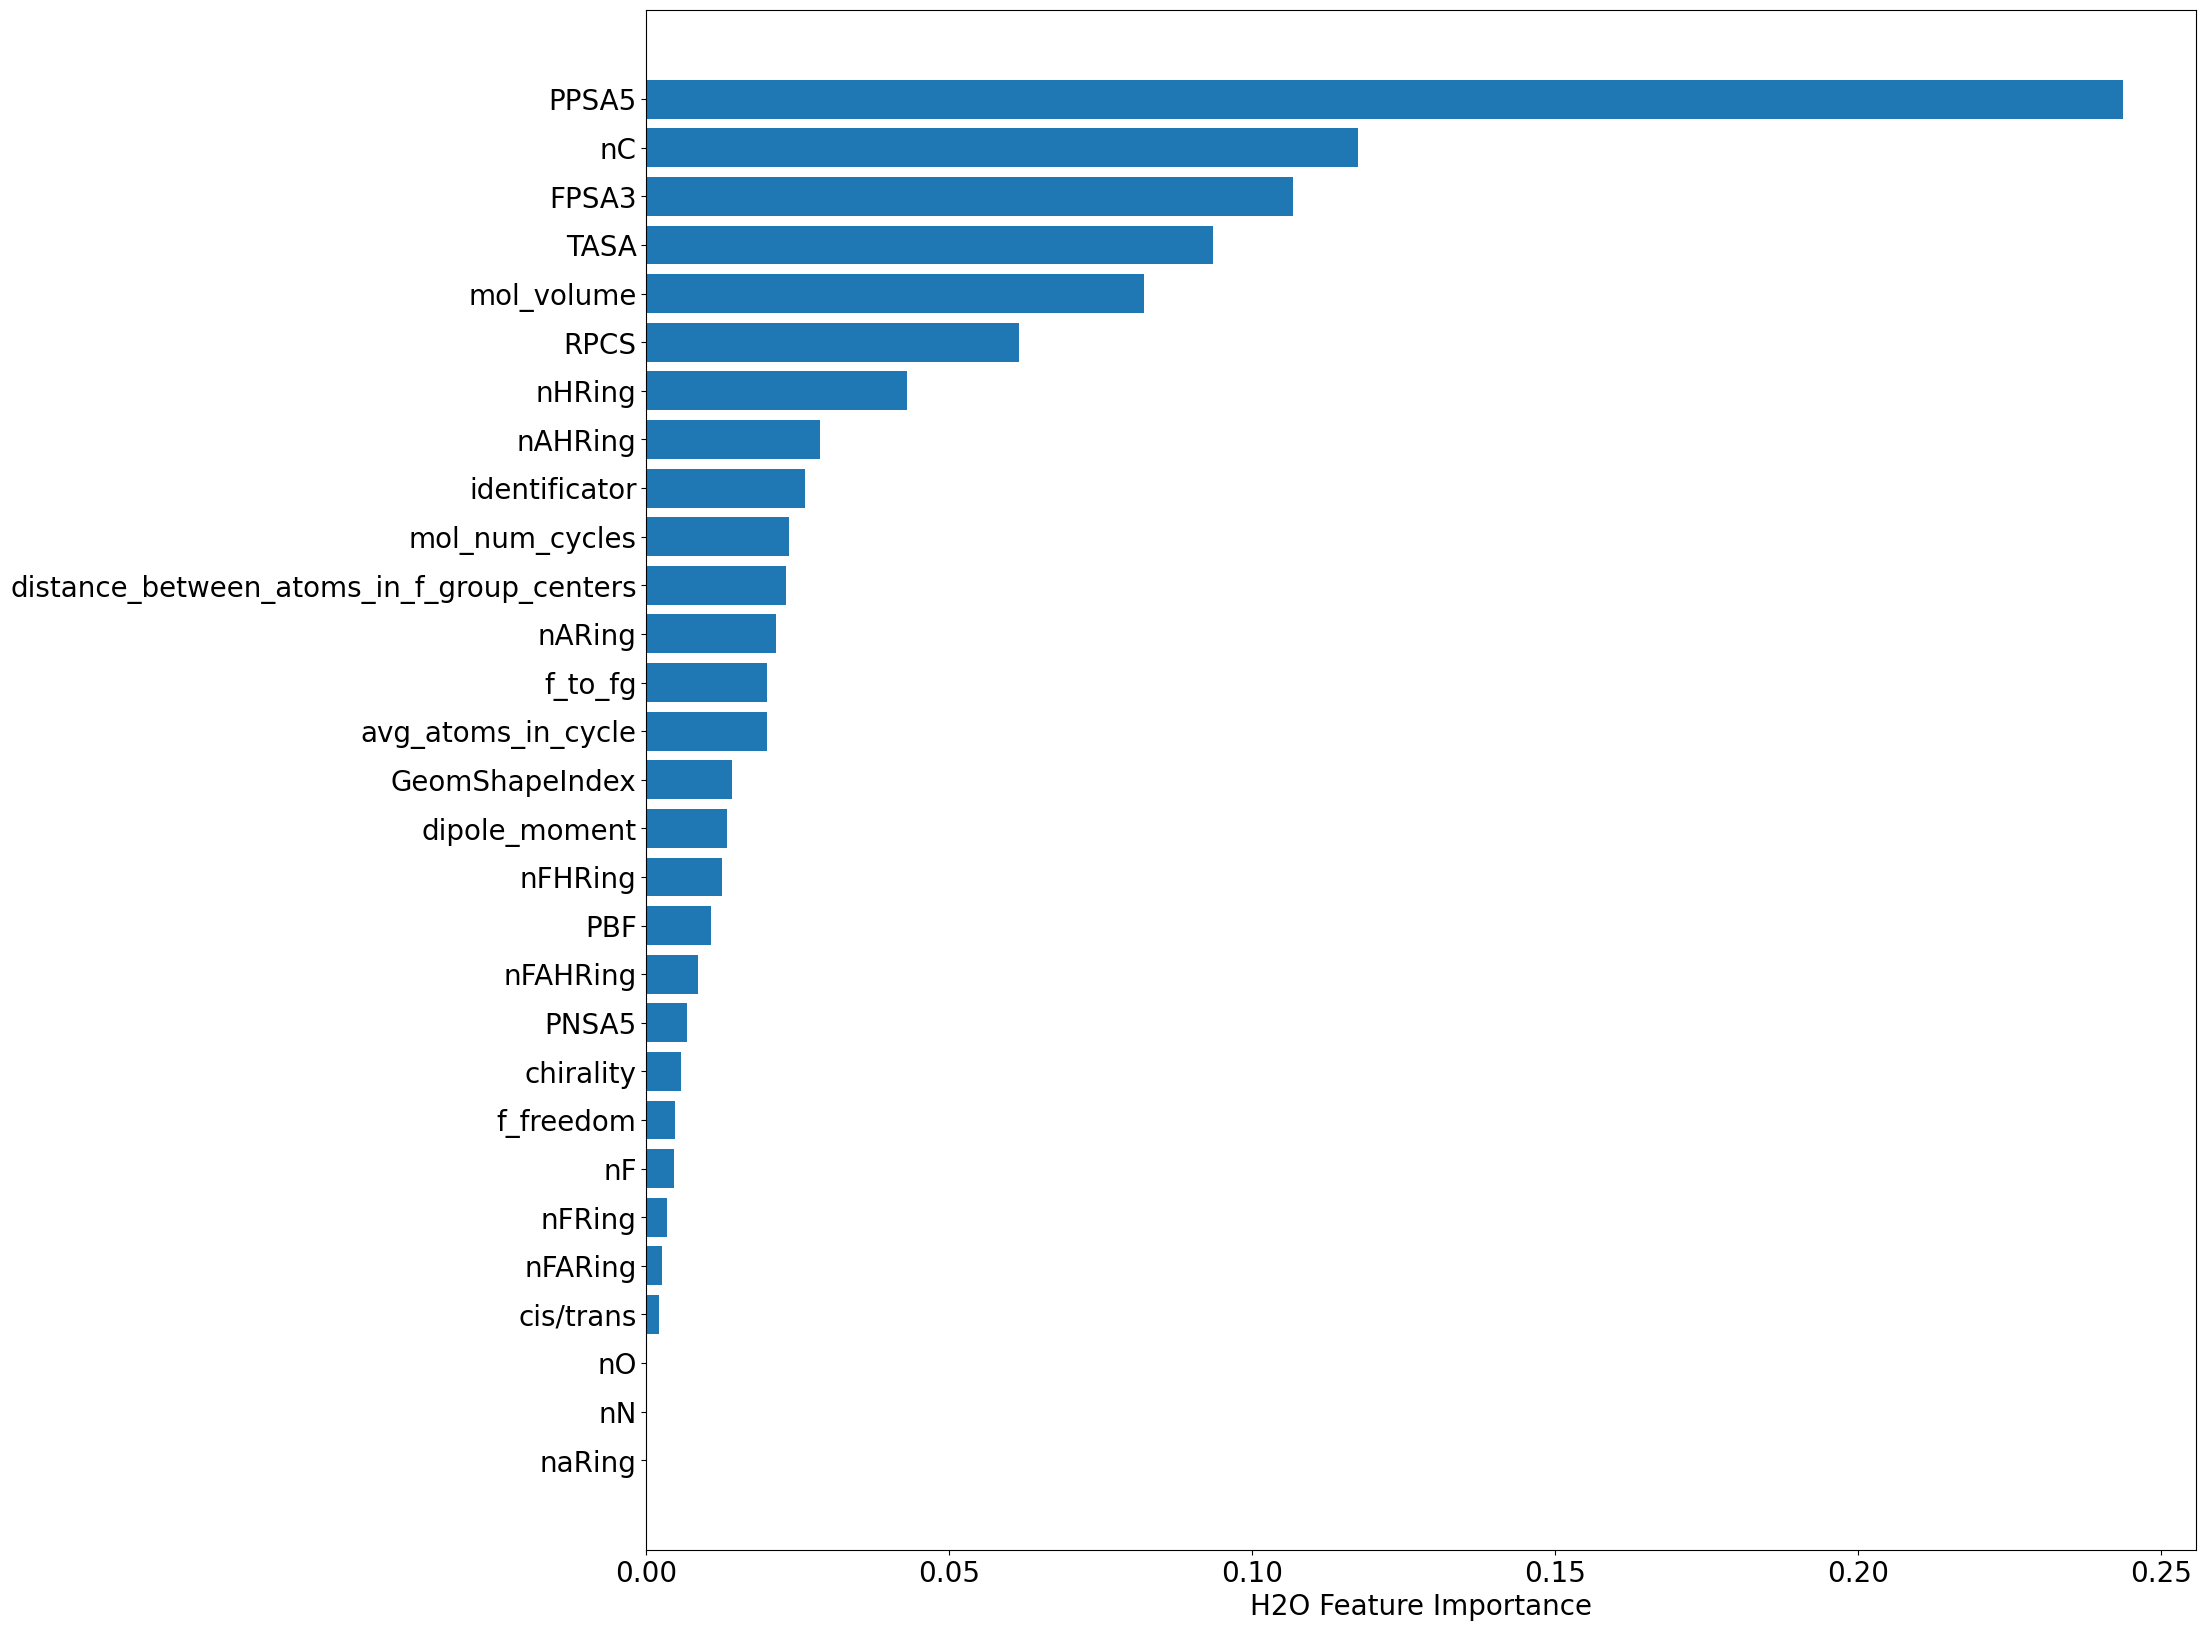

In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=200)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

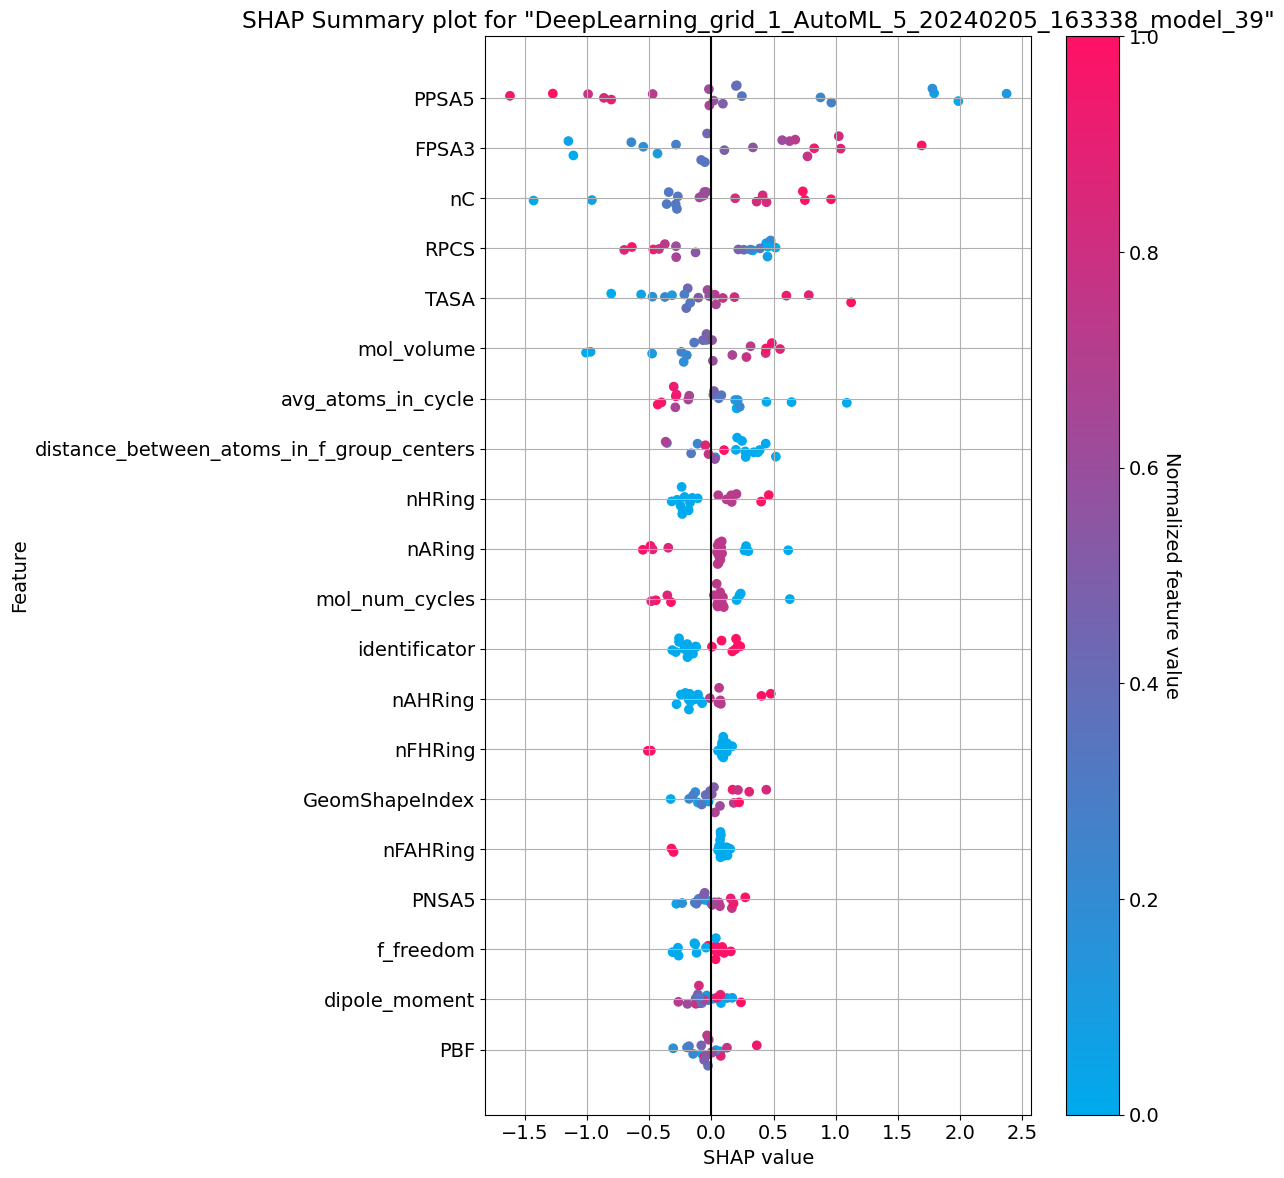

In [13]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=200)

VAR IMPORTANCE

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Text(0.5, 0, 'Percent')

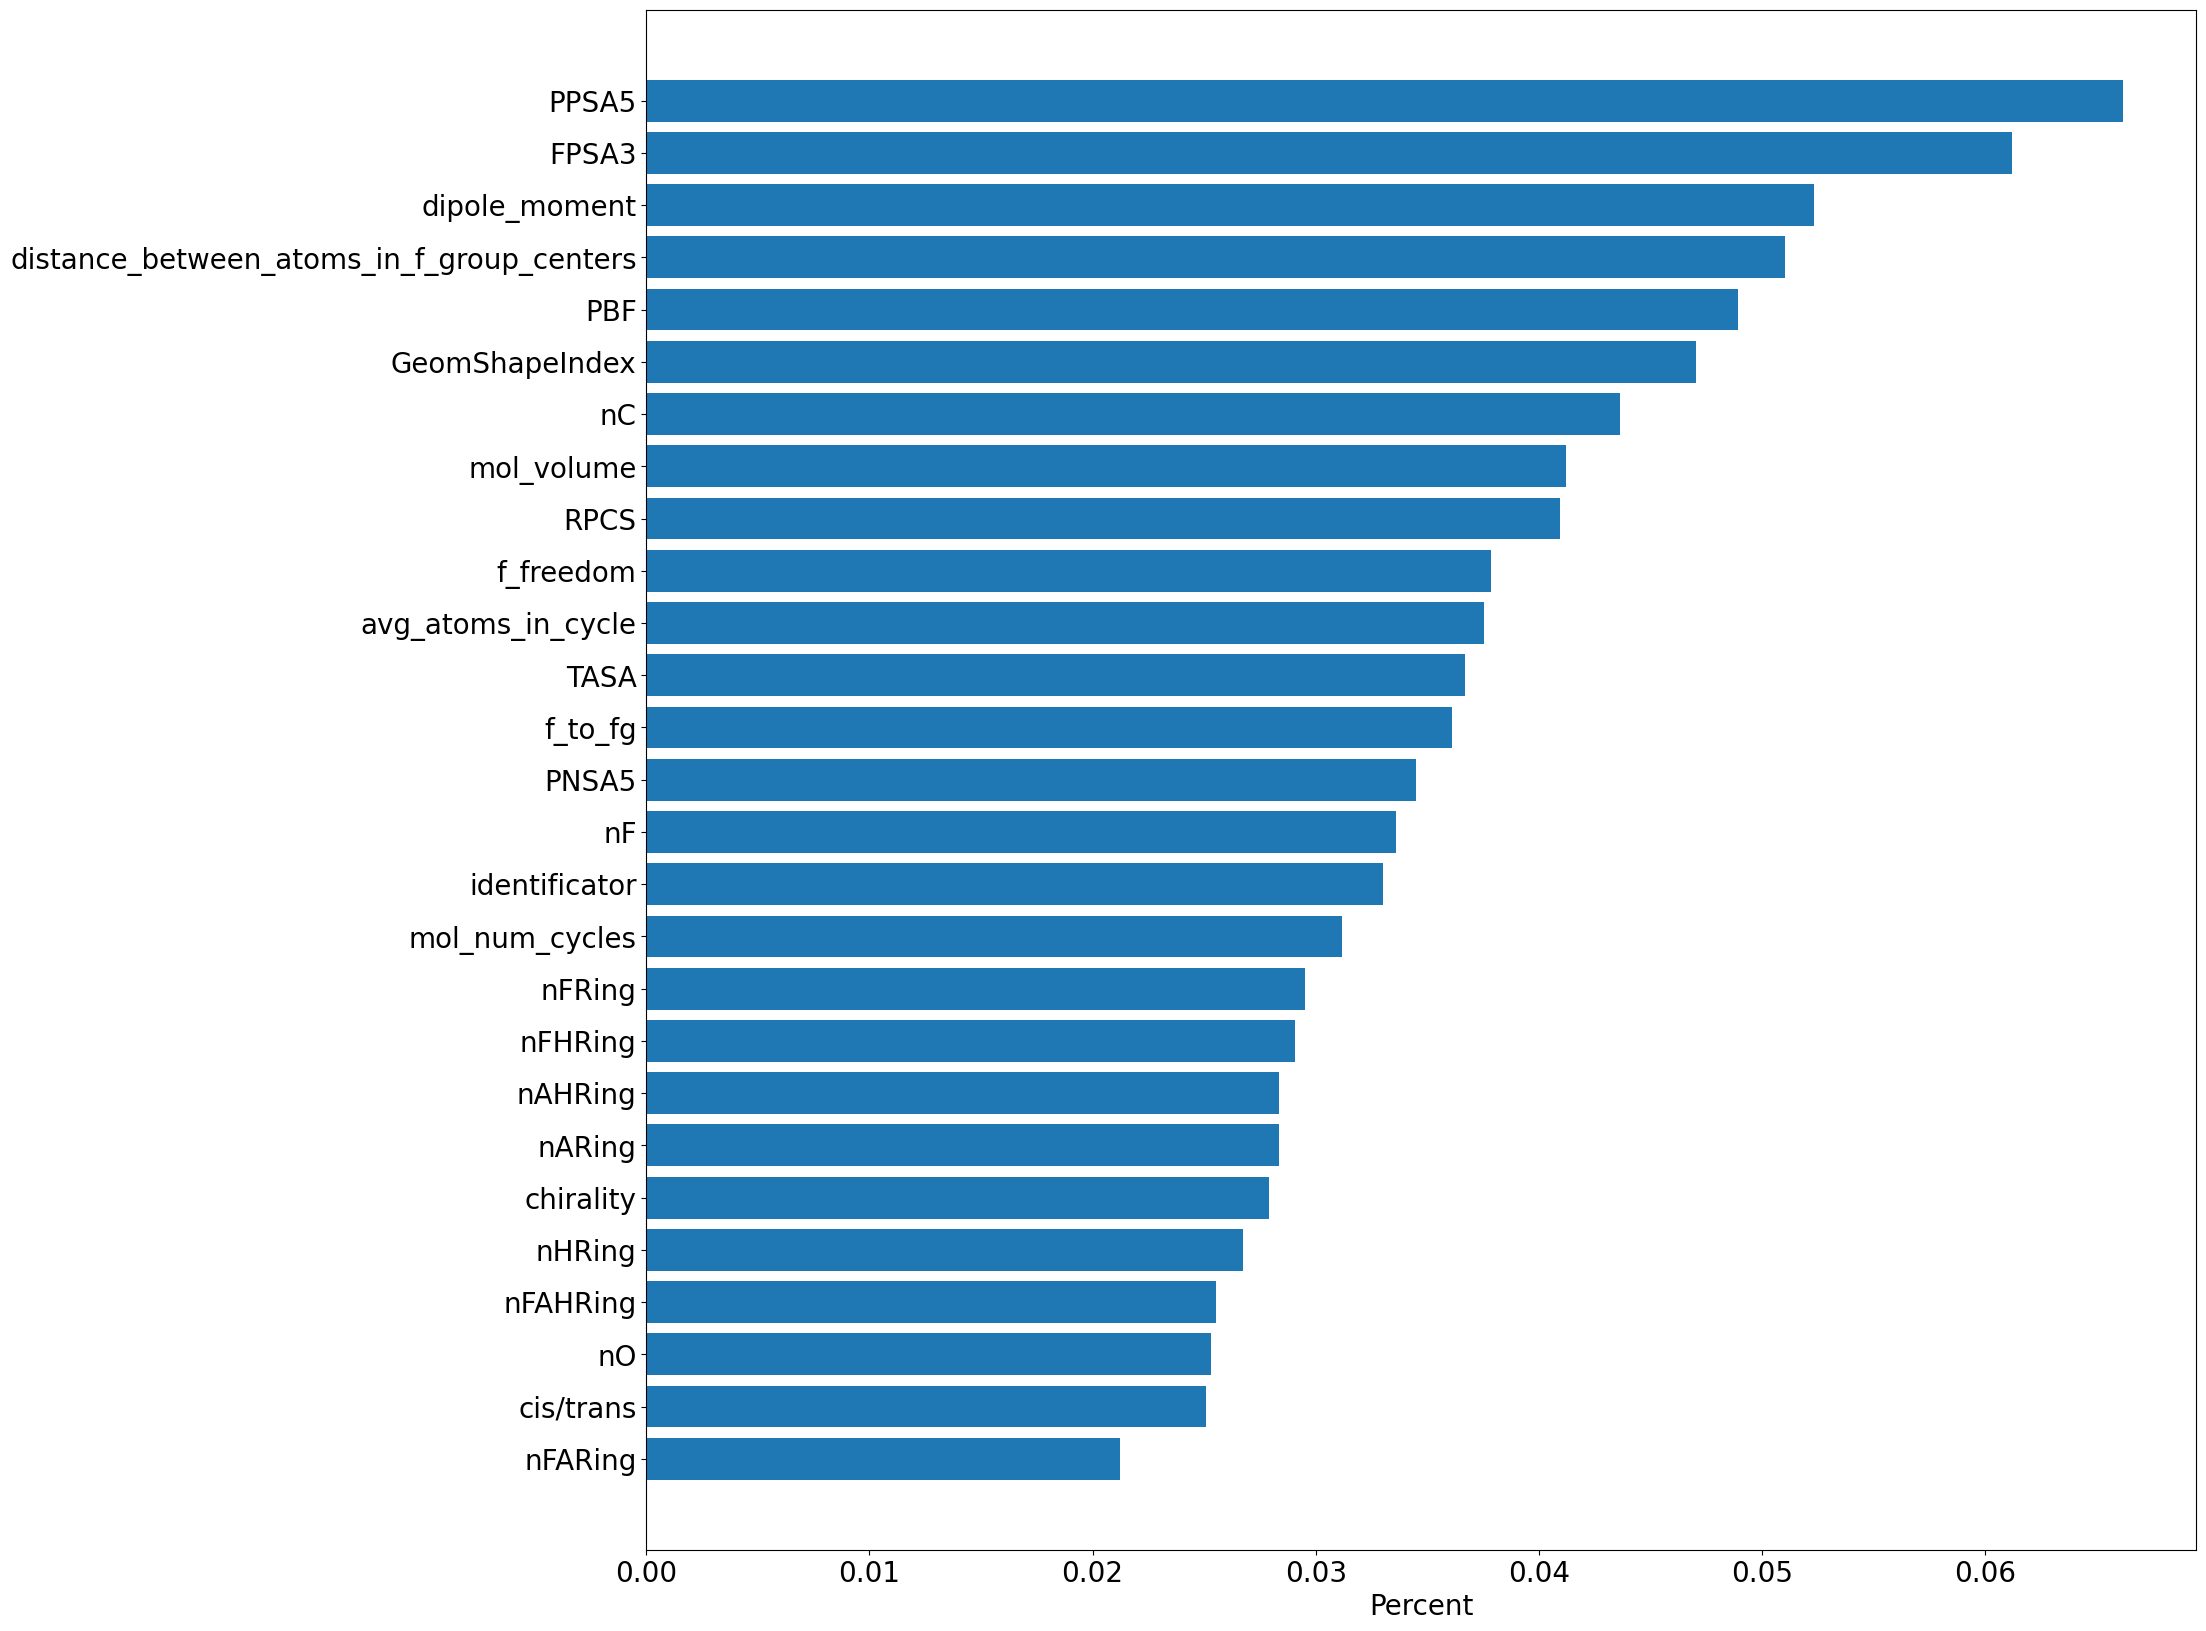

In [14]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

importance = best_model.varimp(test)

fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
ax.set_xlabel('Percent')


BEST MODEL SAVING

In [15]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\pKa_acid_amine\amine'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'all_molecules(without_angle_feature)_without_outliers_amine_model_sort_by_cv'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\pKa_acid_amine\\amine\\all_molecules(without_angle_feature)_without_outliers_amine_model_sort_by_cv\\DeepLearning_grid_1_AutoML_5_20240205_163338_model_39'